# Imports

In [1]:
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

import os

import json

from sklearn.model_selection import train_test_split

import t
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import string

import re

# Constants

In [2]:
BASE_DATA_PATH = os.path.join('fumseck', 'app', 'model')

MODEL_LOSS = 'categorical_crossentropy'
MODEL_OPTIMIZER = 'adam'
MODEL_DENSE_ACTIVATION = 'softmax'
MODEL_EMBEDDING_SIZE = 10 
MODEL_LSTM_OUTPUT_DIM = 100
MODEL_DROPOUT_RATE = 0.2

EPOCHS = 300

# Seeds

In [4]:
def seed_everything(seed_value = 0):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value)
    tensorflow.set_random_seed(seed_value)
    
seed_everything()

NameError: name 'tensorflow' is not defined

# Read dataset

In [3]:
def read_json(directory, filename):
    path = os.path.join(directory, filename)
    return pd.read_json(path)['quizz']

dataframes = [read_json(BASE_DATA_PATH, dataset) for dataset in os.listdir(BASE_DATA_PATH)]

In [4]:
def get_anecdotes(dataframes):
    anecdotes = []
    for i in range(0, len(dataframes)):
        df = dataframes[i]
        for level in ['debutant', 'confirme', 'expert']:
            for j in range(0, len(df[level])):
                anecdotes.append(df[level][j]['anecdote'])
    return anecdotes

anecdotes = get_anecdotes(dataframes)

# Preprocess

In [5]:
def preprocess(anecdote):
    anecdote = re.sub("'|«|»", " ", anecdote)
    translator = str.maketrans("", "", string.punctuation)
    anecdote = anecdote.translate(translator)
    anecdote = re.sub(" +", " ", anecdote)
    return anecdote.lower()

anecdotes = [preprocess(anecdote) for anecdote in anecdotes]

# Generate sequence of N-grams tokens

In [6]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    return total_words

total_words = get_sequence_of_tokens(anecdotes)
print(f"There are {total_words} tokens")

There are 2208 tokens


In [7]:
token_list = [tokenizer.texts_to_sequences([anecdote])[0] for anecdote in anecdotes]

In [8]:
tokenizer = Tokenizer()

def get_n_grams_sequence(corpus):
    
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words
    
inp_sequences, total_words = get_n_grams_sequence(anecdotes)

# Padding sequences and feature-target dataset

In [15]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label, max_sequence_len

predictors, labels, max_sequence_len = generate_padded_sequences(inp_sequences)

In [16]:
print(f"Datas have shape, features : {predictors.shape}, targets: {label.shape}")

Datas have shape, features : (5023, 29), targets: (5023, 2208)


# Split in train-validation set

In [21]:
x_train, x_val, y_train, y_val = train_test_split(predictors, labels, test_size=0.2, shuffle= True)

# Create model

In [18]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    
    model = Sequential()
    
    model.add(Embedding(input_dim = total_words, 
                        output_dim = MODEL_EMBEDDING_SIZE, 
                        input_length = input_len))
    model.add(LSTM(MODEL_LSTM_OUTPUT_DIM))
    model.add(Dropout(MODEL_DROPOUT_RATE))
    model.add(Dense(total_words, activation = MODEL_DENSE_ACTIVATION))

    model.compile(loss = MODEL_LOSS, optimizer = MODEL_OPTIMIZER)
    
    return model

model = create_model(max_sequence_len, total_words)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 10)            22080     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2208)              223008    
Total params: 289,488
Trainable params: 289,488
Non-trainable params: 0
_________________________________________________________________


# Model callbacks

In [19]:
model_ckpt_cb = ModelCheckpoint('text_gen_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
es_cb = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
callbacks = [model_ckpt_cb, es_cb]

# Fit model

In [91]:
hist = model.fit(x_train, 
                 y_train,
                 validation_data = (x_val, y_val),
                 epochs = EPOCHS, 
                 verbose = 1, 
                 callbacks = callbacks, 
                 shuffle = True)

Train on 5023 samples, validate on 1005 samples
Epoch 1/100
5023/5023 [==============================] - 11s 2ms/sample - loss: 0.4387 - val_loss: 0.2320
Epoch 2/100
5023/5023 [==============================] - 11s 2ms/sample - loss: 0.4183 - val_loss: 0.2314
Epoch 3/100
5023/5023 [==============================] - 11s 2ms/sample - loss: 0.4258 - val_loss: 0.2281
Epoch 4/100
5023/5023 [==============================] - 11s 2ms/sample - loss: 0.4140 - val_loss: 0.2266
Epoch 5/100
5023/5023 [==============================] - 12s 2ms/sample - loss: 0.4237 - val_loss: 0.2249
Epoch 6/100
5023/5023 [==============================] - 14s 3ms/sample - loss: 0.4105 - val_loss: 0.2178
Epoch 7/100
5023/5023 [==============================] - 12s 2ms/sample - loss: 0.4066 - val_loss: 0.2188
Epoch 8/100
5023/5023 [==============================] - 12s 2ms/sample - loss: 0.4025 - val_loss: 0.2190
Epoch 9/100
5023/5023 [==============================] - 14s 3ms/sample - loss: 0.3999 - val_loss: 0.215

KeyboardInterrupt: 

# Plot training history

<IPython.core.display.Javascript object>


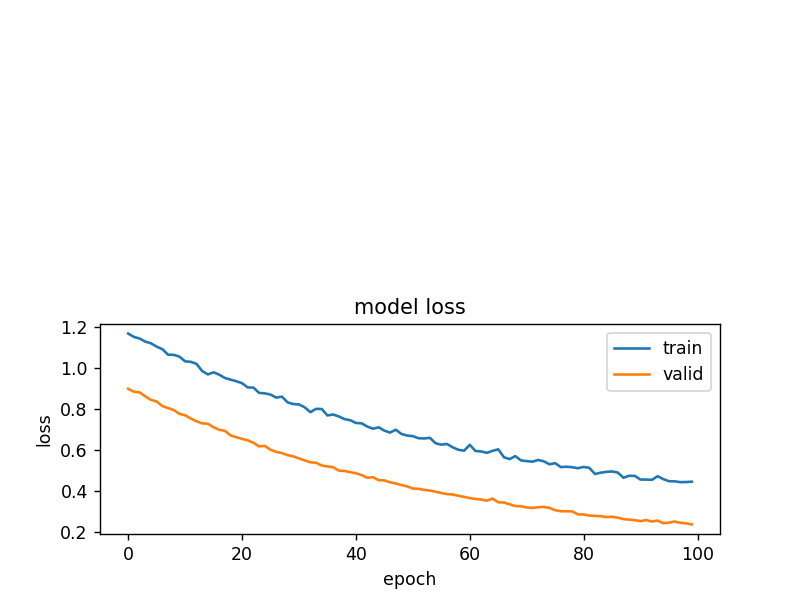

In [71]:
%matplotlib notebook 

def plot_training_hist(hist): 
    plt.plot(hist.history['loss'])  
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid'])
    
plot_training_hist(hist)

# Generate text

In [92]:
def generate_text(seed_text, model, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding = 'pre')
    predicted = model.predict(token_list, verbose = 0)
    predicted = predicted[0].argsort()[-3:]
    print(predicted.shape)
    output_words = []
    for word, index in tokenizer.word_index.items():
        if index in predicted:
            output_words.append(word)
    return output_words

# generate_text("Felix ne prend pas d", model, 30)

# Save vocabulary as json

In [95]:
def save_vocab_as_json(filename, words):
    with open(filename, 'w') as json_file:
          json.dump(words, json_file)
            
save_vocab_as_json('anecedots_vocab.json', tokenizer.word_docs)